---
title: "Orbit products comparison in GNX-py"
bibliography: ../bibliography.bib
---


# Table of Contents

1. [GNX Orbit module](#gnx-orbit-module)
    - [Algorithms and methods](#algorithms-and-methods)
       - [Satellite coordinates](#satellite-coordinates)
       - [Satellite clocks and DCB](#satellite-clocks-and-dcb)
       - [Satellite eclipse periods](#satellite-eclipse-periods)
2. [Example 1 - Broadcast & Precise products comparison](#example-1---broadcast--precise-products-comparison)
3. [Example 2 - Rapid & Final products comparison](#example-2---rapid--final-products-comparison)

# GNX Orbit module
The orbits module of the GNX-py library allows you to compare different GNSS orbit products. In this tutorial, I will discuss the components of the module and show you how to use the code to analyze GNSS products. The core of the orbits module is the SISController class, which integrates a number of GNX-py functions and allows us to compare two GNSS orbit products, both broadcast and precise. The class generates satellite coordinates and clocks from two specified sources and then presents the results in the form of coordinate differences, clocks, and coordinate differences converted to the local satellite system, i.e., in the form of radial, cross-track, and along-track differences. In addition to the above differences, the class also calculates the Signal in Space Error [@GalileoICD2021], or in GPS nomenclature: User Range Error [@ISGPS200N]. These values are the square root of the weighted sum of the squares of the individual components: clock and position differences. The user can adjust the weights for individual components or use the default values. The class also allows for the simultaneous analysis of DCB products assigned to each orbit. In this case, the DCB differences are included in the clock error in the resulting SISE/URE.

This notebook is used to present the use of the orbits module. In the folder, you will find the plotting_tools.py script, which provides default functions for visualizing the results. In the orbit_data folder, you will find the orbit files that I will use for the presentation. The algorithms and implementation details can be found in the next section.

## Algorithms and methods
When implementing methods and algorithms, I relied on information described in [@Montenbruck2018_SISRE; @Montenbruck2014].

Calculations in the SISController class can be summarized in the following points.

- Generate satellite coordinates and clocks for the given epoch 
- Determine the difference between the above 
- Create a local satellite layout based on the reference orbit 
- Convert errors $\Delta{XYZ}$ to $\Delta {RAC}$
- Using $\Delta{RAC}$, calculate the signal in space error 
- Return an array with the calculated differences and SISE 

Now I will discuss the approaches used for satellite coordinates and in the next section, methods of handling satellite clocks and DCB's. They require a special approach that is worth discussing separately.

### Satellite coordinates
Let's consider a comparison between the broadcast and precise orbits. Suppose we want to investigate how accurate the broadcast orbit and clock are in relation to the precise final product. We want to obtain coordinate errors and errors in the local satellite system in order to better understand the distribution of errors in the orbital plane. The coordinates we obtain from the navigation message data are referenced to the satellite antenna phase center (APC), while the coordinates in SP3 products are referenced to the satellite center of mass (COM). Therefore, we cannot directly compare the two sets of coordinates because they are referenced to different points. A direct comparison of these two types of coordinates will lead to offsets of approximately 1-2m. Fortunately, analysis centers provide ANTEX files with the .atx extension, which contain PCO (phase center offsets) that we can use to refer our coordinates to a single location. If we apply PCO into the precise COM coordinates we obtain APC coordinates. The .ATX file is necessary for the correct execution of the task we are considering here. GNX-py will also perform the calculations if we do not provide it, but as I mentioned, the results obtained in this case will be subject to a large error. GNX-py enables reading ATX files. Let us now discuss the algorithms used.


In .ATX files, we find PCO for satellites in a local satellite system, created by three vectors [@Handbook].
$$\begin{aligned}
    e_1 = \frac{r_{sat}}{|{r{sat}|}}\\
    \space 
    \space 
    e_2 = e_{1} \times \hat{e}\\
    \space 
    \space 
    \hat{e} = \frac{r_{sun} - r_{sat}}{|r_{sun}-r_{sat}|}\\
    \space 
    \space 
    e_3 = e_2 \times e_1
\end{aligned}$$
Where: 
- $r_{sat}$, $|{r_{sat}}|$  are satellite position vector and norm of that vector 
- $r_{sun}$ is the Sun position vector
- $e_1$ is the unit vector pointing to the geocentre 
- $\hat{e}$  is the unit vector pointing from tha satellite to sun 
- $e_2$ is the cross product of $e_1$ and $\hat{e}$ 
- $e_3$ completes the right handed system

Having satellite PCO in satellite fixed system, we can bring satellite COM coordinates into APC coordinates by creating rotation matrix: 
$$\begin{aligned}
    rot = [e_3, e_2, e_1] \\
\end{aligned}$$

Denoting PCO as $\Delta{APC}$ and satellite COM coordinates as $XYZ_{COM}$ we obtain APC coordinates - $XYZ_{APC}$ by applying: 
$$\begin{aligned}
    XYZ_{APC} = XYZ_{COM} + rot \cdot\Delta{APC}\\
\end{aligned}$$

With the APC coordinates of the satellites, we can simply subtract them and convert the differences obtained into differences in the satellite's orbital plane. To do this, we will use the orbital reference system, created by the R, A, and C vectors:
$$\begin{aligned}
    R =  \frac{r_{sat}}{|{r{sat}}|}\\
    A = \frac{r_{sat} \times v_{sat}}{|r_{sat} \times v_{sat}|}\\
    C = e_3 \times e_1
\end{aligned}$$
Where $v_{sat}$ is the satellite velocity vector. The differences $\Delta_{RAC}$ are obtained by [@HofmannWellenhof2008]:
$$\begin{aligned}
    \Delta R = R \cdot \Delta{XYZ}\\
    \space 
    \Delta A = A \cdot \Delta{XYZ}\\
    \space 
    \Delta C = C \cdot \Delta{XYZ}
\end{aligned}$$

With the differences determined in this way, the software uses the formula for SISE/URE:
$$\begin{aligned}
    SISE = \sqrt(w_R \cdot dR^2 + w_{dt} \cdot dT^2 + w_{AC} \cdot (dA^2 + dC^2)+ w_{RdT} \cdot dR \cdot dT) 
\end{aligned}$$
Where $w_R$, $w_{dT}$, $w_{AC}$, $w_{RdT}$ are the weights for individual components. $w_{RdT}$ is used to introduce the correlation between the radial error and the clock error into the equation. As I mentioned, we will move on to how to deal with satellite clocks in the next section. 
It is worth noting that the RTN system is created using the current position and velocity of the satellite. In the case of broadcast orbits, we have access to both of these values, because satellite velocities can be obtained using a classic algorithm for converting Keplerian orbit elements to ECEF coordinates. However, in the case of SP3 orbits, if the velocities are not specified in the file, which is often the case, we do not have access to the satellite velocities. Simply differentiating the positions between two epochs, separated by, for example, 30 seconds or even just 1 second, will not allow us to precisely determine the satellite's velocity from the SP3 coordinates. You can see for yourself by trying to generate and differentiate coordinates from the broadcast orbit, and then compare them with the velocities. The satellite velocity for SP3 data is needed both to create the RTN system and to determine the relativistic clock correction. GNX-py implements the following approach: assuming that we interpolate the satellite position at epochs $t_0$, $t_1$, $t_2$ ... $t_n$, for each time step we also interpolate the position $t_n$ - $0.5 \mu$ s and $t_n$ + $0.5 \mu$ s. Such a small time step means that the neighboring coordinates are very close to each other, and the difference between these positions gives the actual instantaneous velocity of the satellite at a given time step tn.

The above problem may not occur if we compare the precise and broadcast orbits, as we can create an RTN system based on the broadcast positions and velocities. However, when comparing precise products (e.g., Ultra Rapid and Final), we have to deal with this inconvenience. In GNX-py, in the SISController class, one of the orbits is “reference” and data from this orbit is used to create the RTN system - it is up to the user to decide whether it will be broadcast or precise orbit.

### Satellite clocks and DCBs
I would like to discuss satellite clocks and DCBs separately, due to the special treatment they receive. Precise and broadcast offsets of satellite clocks are characterized by slight differences in relation to global time scales, such as TAI and UTC. Broadcast ephemerides are referenced to the time scale specific to the constellation, similarly, precise products are associated with a product-specific scale. Thus, clock values should not be compared directly, due to this difference in the implementation of the time scale specific to a given GNSS.  This bias can be removed by correcting the “raw” differences in clock offset values between two products by the average difference in clock offset values in a given epoch for the entire constellation under analysis [@Montenbruck2018_SISRE, @Montenbruck2014]. That is: at each epoch, we calculate the raw clock difference for each satellite, and the average clock difference for the entire constellation at that epoch. In GNX-py, we can use the mean or median to calculate the correction value, or ignore this bias entirely.


In GNX-py, for orbit and clock error analysis, we can also enable comparison of transmitted TGD broadcasts and DCB from precise .BIA/.BSX products. They can (and should) be treated in the same way as clocks, i.e., with the application of the average difference (TGD-DCB) per epoch. Currently, the algorithm supports the use of both DSB and OSB products for comparisons with TGD broadcasts, but in the latter case, OSB is converted to DSB. Since the transmitted DCBs are associated with specific signals for GPS and Galileo, i.e., combinations of IF C1W-C2W for GPS, C1C-C5Q, C1C-C7Q for F/NAV and I/NAV for Galileo, the comparison is made between the transmitted TGD and the corresponding bias from the precision products.

### Satellite eclipse periods 
GNX-py orbits module also provides the ability to determine the time perid when the satellite is in Earth's shadow. The entry of a satellite into the Earth's shadow can cause effects such as a disturbance in motion visible as an increase in the errors of orbital components, or a jump in the value of clock errors caused by a change in temperature. This functionality can be useful for users who want to use the module to study the stability of satellite orbits in these eclipse periods. In GNX-py, the eclipse period is determined by formulas [@Mervart1995]:

$$\begin{aligned}
    cos(\phi) = \frac{r^{sat} \cdot r^{sun}}{\boldsymbol{r^{sat}} \cdot\boldsymbol{r^{sun}}}<0 \\\\
    \sqrt{1-cos^2(\phi)}<a_e\\
\end{aligned}$$

Where $r^{sat}$ and $r^{sun}$ are vectors from the geocentre to the satellite and Sun respectively, and $\boldsymbol{r^{sat}}$ and $\boldsymbol{r^{sun}}$ are norms of these vectors, and $a_e$ is the mean equatorial radius of Earth. If these equations are satisfied, we are dealing with an eclipse period.


Let us conclude the theoretical introduction here and move on to examples of using GNX-py for orbit analysis. In the following sections, we will refer to the information discussed here.

## Example 1 - Broadcast & Precise products comparison


As with SPP and PPP, we use a configuration and management class to analyse orbits. However, the configuration class differs slightly from those used in the two previous cases.  In the $SISConfig$ class, we have the following parameters:
- $orb\_path\_0$ and $orb\_path\_1$  - Broadcast or SP3 orbit files
- $dcb\_path\_0$  and $dcb\_path\_1$ - DCB .BIA/.BSX or Broadcast files
- $atx\_path$ - ANTEX file
- $systems$ - G or E - system to be used
- $gps\_mode$ and $gal\_mode$ - GNSS signals, essentially a choice between PCO and, in the case of Galileo, INAV and FNAV orbits
- $interval$ - interval at which to calculate satellite coordinates
- $apply\_eclipse$ - whether to calculate the time the satellite spends in the Earth's shadow
- $extend\_eclipse$ - whether to extend the eclipse flag
-$extension_time$ - time to extend the eclipse duration flag, default 30 min
- $apply\_satellite\_pco$ - whether to enter satellite PCO
- $clock\_bias$ - whether to correct the clock error by the average bias per epoch
- $clock\_bias\_function$  - which function to use to calculate the bias: choose between “meand” or 'median'
- $tlim$ - time range for calculating satellite coordinates




In [2]:
import gps_lib as gnx 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from plotting_tools import df_head
np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True, precision=3)


Let us examine the errors of the IGS broadcast orbit against the final CODE products. Let us assume that we are interested in the orbit performance for a single-frequency user. We will select a 5-minute interval for calculating coordinates, correct the clock for the average bias per epoch, and limit our analysis to 12 hours to save time.

In [3]:
ORBIT_0 = '../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
ORBIT_1 = '../data/COD0OPSFIN_20240350000_01D_05M_ORB.SP3'

ATX = '../data/ngs20.atx'
DCB_1 = '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
TLIM = [datetime(2024,2,4,0,0,0), datetime(2024,2,5,0,0,0)]

We fill in the configuration class: $SISConfig$, according to previous assumptions.

In [4]:
config = gnx.SISConfig(orb_path_0=ORBIT_0,
                   dcb_path_0=ORBIT_0,
                   orb_path_1=ORBIT_1,
                   dcb_path_1=DCB_1,
                   atx_path=ATX,
                   interval=30,
                   system='G',
                   gal_mode='L1L2',
                   clock_bias=True,
                   clock_bias_function='mean',
                   apply_eclipse=True,extend_eclipse=True,extension_time=30,
                   compare_dcb=False,
                   tlim=TLIM)

We start processing with the $run$ method. The result is a dataframe containing errors/differences between orbit 0 and orbit 1. I'm using the term ‘differences’ here because the word ‘errors’ implies that one orbit is worse than the other. This does not have to be the case, unless we deliberately treat one orbit as a reference. In our case, however, this is exactly what we do – we treat the CODE final orbit as a reference relative to IGS broadcast orbit.

In [5]:
df = gnx.SISController(config=config).run()

[diag] G01: epochs=2881, NAV=14, in_window=2881


The columns $dR, dA, dC, dt$ in our dataframe are errors in the Radial, Cross-Track and Long-track planes, and the satellite clock. $dTGD$ are errors in the DCB value – for the broadcast orbit, this will be the transmitted TGD, for DCB – the value from the .BSX file for a given satellite. The columns $sisre_{orb}, sisre, sisre_{notgd}$ are signal-in-space error values calculated according to the formula presented in the introduction. The suffixes $\_orb \ and \ \_notgd$ mean that the given value was calculated without taking into account the clock error and without taking into account the TGD/DCB error.

In [6]:
print(df.columns.tolist())

['dR', 'dA', 'dC', 'dt', 'dt_mean', 'dTGD', 'dTGD_mean', 'sisre', 'sisre_orb', 'sisre_notgd', 'dx', 'dy', 'dz', 'eclipse_raw', 'eclipse']


In [7]:
df_head(df,nrows=3,ncols=6)

| sv   | time                |    dR |    dA |     dC |     dt |
|------|---------------------|-------|-------|--------|--------|
| G02  | 2024-02-04 00:00:00 | 0.026 | 0.694 |  0.084 | -0.030 |
| G02  | 2024-02-04 00:00:30 | 0.192 | 1.777 | -0.475 |  0.026 |
| G02  | 2024-02-04 00:01:00 | 0.173 | 1.711 | -0.449 |  0.033 |

The $plotting\_tools.py$ file contains auxiliary functions for visualising our results. The graph shows all $SISE$ components and the three $SISE$ values discussed above. You can assess the impact and behaviour of each component.

In [12]:
from plotting_tools import plot_sisre

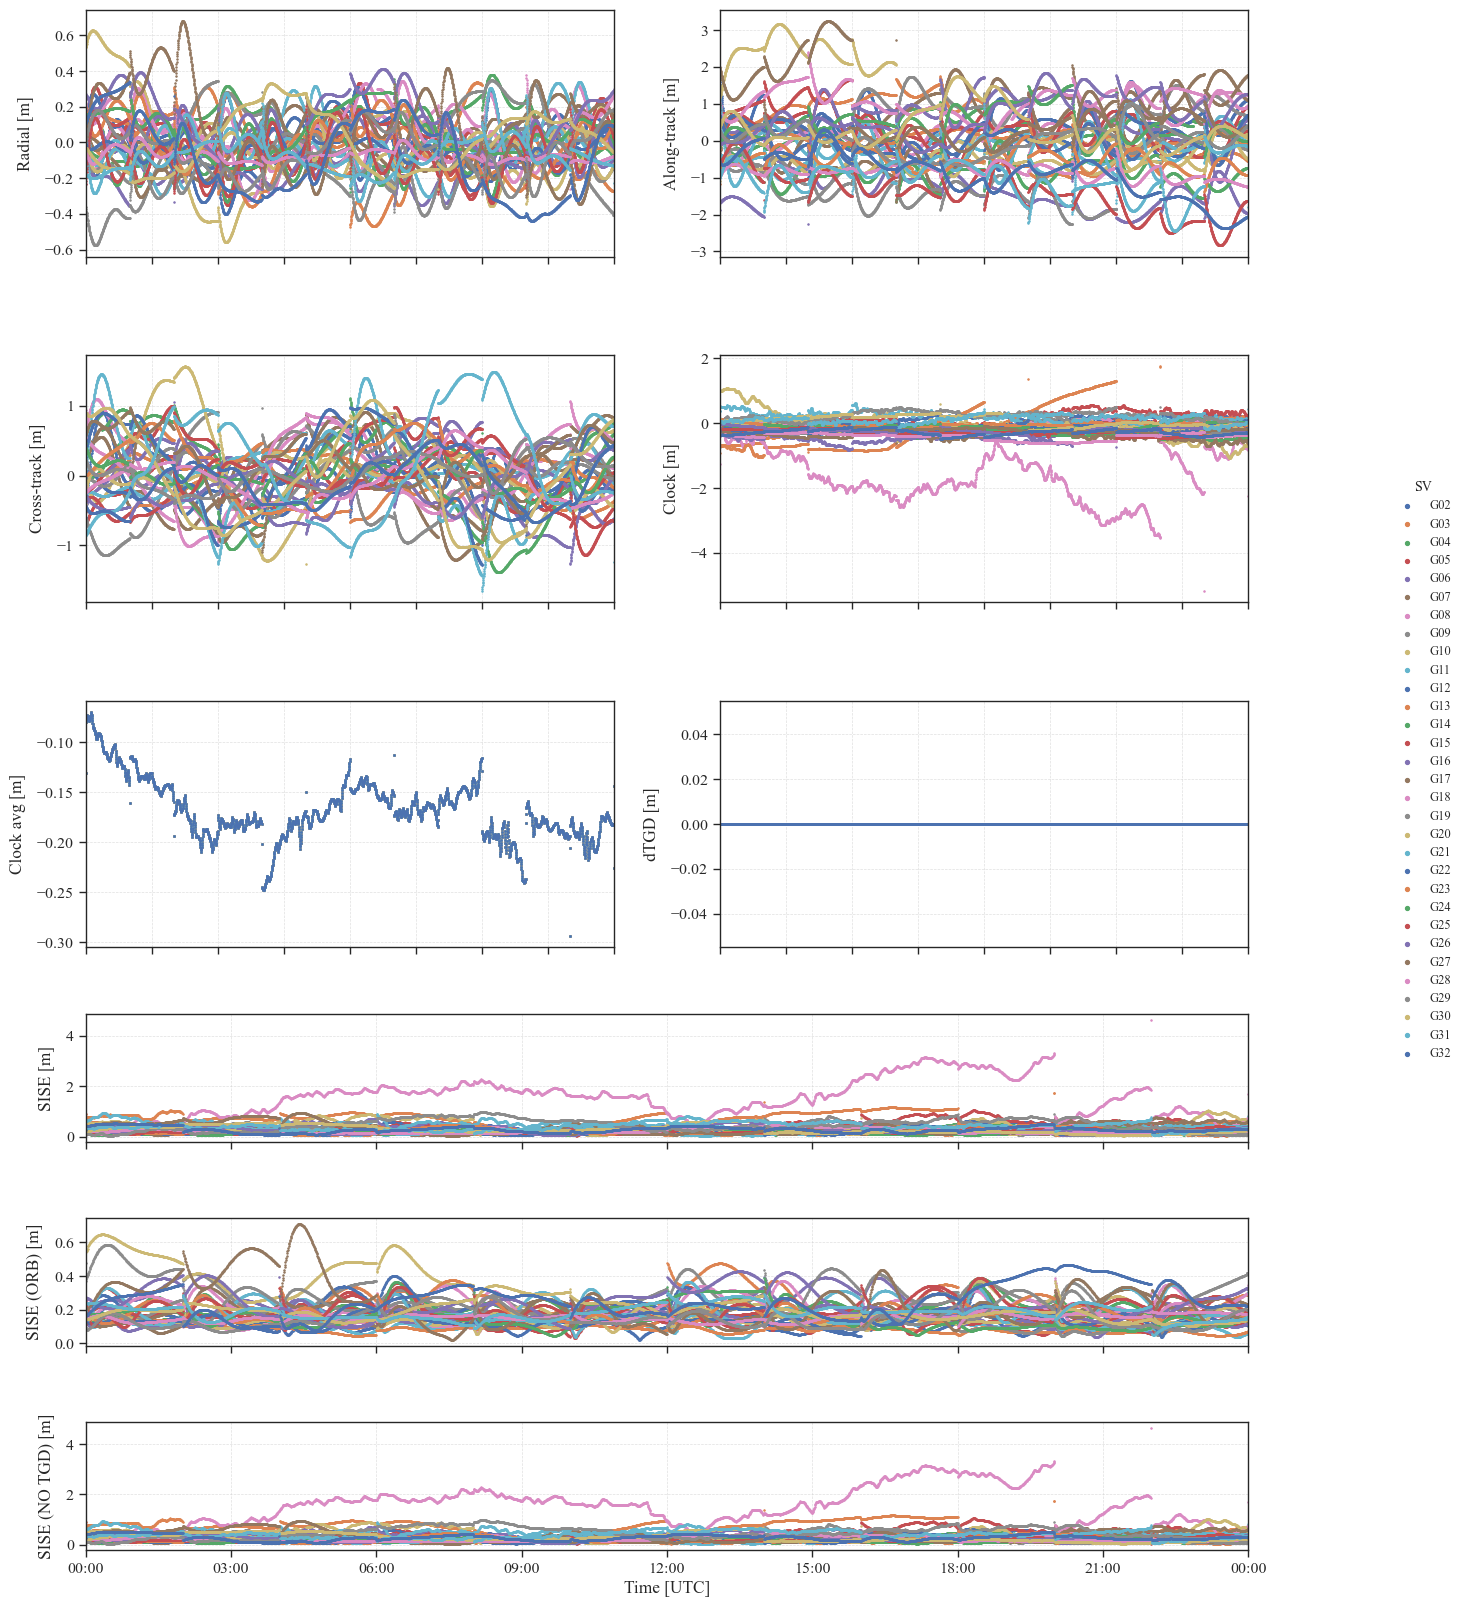

In [15]:
plot_sisre(df=df,out_path='./figures',name='myorbits')

In the top three rows, you can see all the components that make up $SISE$. The $Clock \ avg$ graph is the correction applied to the clock error - the average clock error across the entire constellation per epoch.

Additionally, in the $stat\_tools.py$ file, you will find the $orbit\_stats$ function, which allows you to calculate basic statistics for a selected column or set of columns. Using the $plot\_stats$ function, you can visualise the obtained statistics on a bar chart.

In [17]:
from stat_tools import orbit_stats

In [18]:
stats = orbit_stats(df=df,columns='sisre')

In [19]:
df_head(stats,nrows=3,ncols=6)

| sv   |   sisre_min |   sisre_max |   sisre_mean |   sisre_median |   sisre_95% |
|------|-------------|-------------|--------------|----------------|-------------|
| G02  |       1.015 |       1.594 |        1.319 |          1.320 |       1.525 |
| G03  |       0.113 |       1.232 |        0.421 |          0.419 |       0.741 |
| G04  |       0.553 |       1.266 |        0.820 |          0.799 |       1.191 |

In [20]:
from plotting_tools import plot_sv_stats

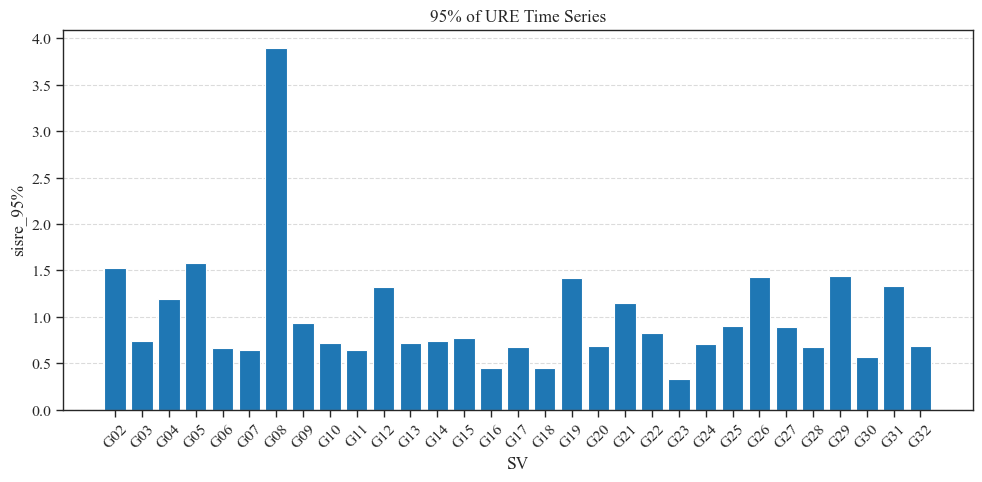

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': '95% of URE Time Series'}, xlabel='SV', ylabel='sisre_95%'>)

In [21]:
plot_sv_stats(stats_df=stats,column_stat='sisre_95%',kind='bar',title='95% of URE Time Series')

You have probably already noticed that clock error and TGD have a key impact on the size of SISE. In fact, TGD error sometimes exceeds the scale of the clock error itself. To learn more about this phenomenon, you can use the GNX-py library to analyse DCB/TGD itself. As reported by X, among others, we are dealing with either OSB or DCB biases (we mentioned them briefly in the notebook dedicated to PPP). X discusses the relationship between TGD transmitted in broadcast messages and DSB, and between OSB and DSB. We can easily compare DSB with TGD, and convert OSB to DSB, thus obtaining three values that we can treat as relating to the same phenomenon - the hardware delay of the satellite transmitter.

Let us open and compare the TGD and DCB files that we processed in our $SISController$. Additionally, let us open the .BIA file with the final OSB biases. We will load the files in $GNSSDataProcessor$ and perform selections and visualisations in pandas and matplotlib.

In [22]:
dcb_1, dcb_type = gnx.GNSSDataProcessor2(sys='G').read_bia(path=DCB_1)
DCB_2 = '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
dcb_2, dcb2_type = gnx.GNSSDataProcessor2(sys='G',galileo_modes='L1').read_bia(path=DCB_2)
print('DCB TYPE: ', dcb_type, '\n')
print('DCB 2 TYPE: ', dcb2_type, '\n')

DCB TYPE:  DSB 

DCB 2 TYPE:  OSB 



From the opened DCB files, we only extract those for GPS.

In [23]:
gps_dcb = dcb_1.loc[(dcb_1.index.get_level_values('sv').str.startswith('G'))]
gps_dcb2 = dcb_2.loc[(dcb_2.index.get_level_values('sv').str.startswith('G'))]
df_head(gps_dcb,nrows=3,ncols=5)

| sv   | time                |   BIAS_C1C_C2C |   BIAS_C1C_C2L |   BIAS_C1C_C2P |
|------|---------------------|----------------|----------------|----------------|
| G    | 2024-02-04 00:00:00 |        -22.406 |          0.000 |          0.000 |
| G01  | 2024-02-04 00:00:00 |          0.000 |          0.000 |          0.000 |
| G02  | 2024-02-04 00:00:00 |          0.000 |          0.000 |          0.000 |

Now we need to load the broadcast orbit for GPS.

In [24]:
nav = gnx.GNSSDataProcessor2(sys='G',nav_path=ORBIT_0,galileo_modes='L1L2').load_broadcast_orbit()
brdc = nav.gps_orb


In [25]:
brdc=brdc.reset_index()
brdc['sv'] = brdc['sv'].str[:3]
brdc = brdc.set_index(['sv','time'])
sats=brdc.index.get_level_values('sv').unique().tolist()

As described in X, $DSB(obs1, obs2) = OSB (obs2) - OSB(obs1)$, while for TGD transmitted in a broadcast message $TGD = k2 \times DSB(C1W, C2W)$, where $k2 = \frac{-f2^{2}}{f1^{2}-f2^{2}}$ , $f1, f2 =1575.42, 1227.60 MHz$
In our case, therefore, $obs1, obs2$ are C1W and C2W.

In [26]:
C=299792458
f1 = 1575.42e06
f2 = 1227.60e6
f2 = 1176.45e6
k2  = -f2**2/(f1**2-f2**2)

Let's write a simple code that will calculate and show us the differences in TGD. As you can see, the differences between TGD and DCB from the .BSX file and those converted from the .BIA file amount to several metres, while the differences between the values from the .BSX/.BIA files are less than 20 cm, bearing in mind that they originate from different centres and are different types of products: rapid and final.

In [27]:
d1, d2, d3 = [], [], []
ns2m = 1e-09*C
for sat in sorted(sats):
    tgd = (brdc.loc[sat,'TGD'].unique()/1e-09)[0].round(4)
    dcb = k2*gps_dcb.loc[sat,'BIAS_C1W_C2W'].unique()[0].round(4)
    dcb2 = k2*(gps_dcb2.loc[sat,'OSB_C1W'] - gps_dcb2.loc[sat,'OSB_C2W'] ).unique()[0].round(4)
    d1.append(np.round(tgd-dcb,3)*ns2m)
    d2.append(np.round(tgd-dcb2,3)*ns2m)
    d3.append(np.round(dcb-dcb2,3)*ns2m)

Using matplotlib, let us visualise our differences on a bar chart.

<BarContainer object of 32 artists>

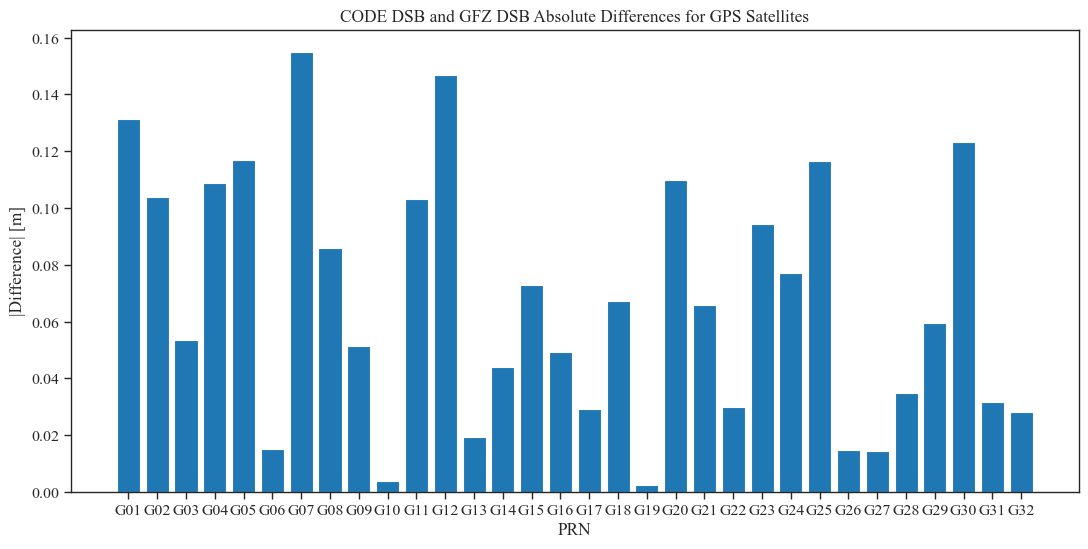

In [28]:
plt.figure(figsize=(13,6))
plt.title('CODE DSB and GFZ DSB Absolute Differences for GPS Satellites')
plt.xlabel('PRN')
plt.ylabel('|Difference| [m]')
plt.bar(sorted(sats), abs(np.array(d3)))

We calculated the differences between TGD and the two types of DSB. We will show them on a common graph using matplotlib. As you can see, the absolute differences are drastically greater than in the case of rapid and final product differentiation.

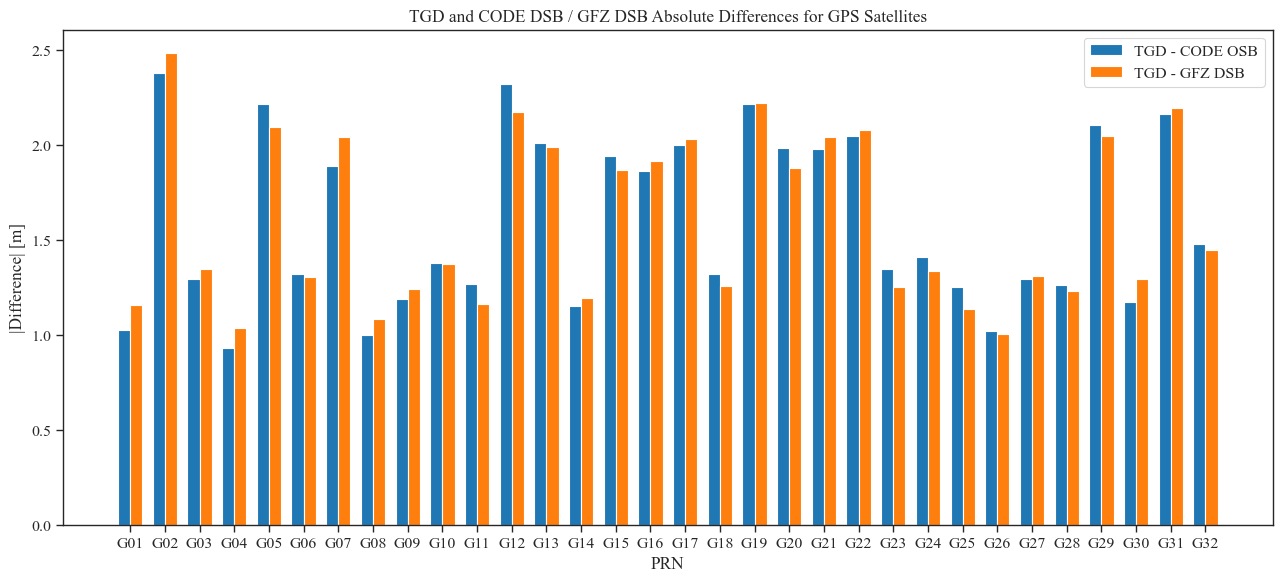

In [29]:
import numpy as np
import matplotlib.pyplot as plt

svs = sorted(sats)
x = np.arange(len(svs))
width = 0.35

plt.figure(figsize=(13,6))
plt.title('TGD and CODE DSB / GFZ DSB Absolute Differences for GPS Satellites')
plt.xlabel('PRN')
plt.ylabel('|Difference| [m]')
plt.bar(x - width/2, np.abs(d1), width, label='TGD - CODE OSB')
plt.bar(x + width/2, np.abs(d2), width, label='TGD - GFZ DSB')

plt.xticks(x, svs)
plt.legend()
plt.tight_layout()
plt.show()


In this example, we used GNX-py functionality to calculate orbit errors and performed some additional DCB component analysis by combining GNX-py functions and popular Python tools. We provided numerical and visual results comparing two types of orbits and TGD/DCB values. You can try replacing the orbits and DCB sources in the configuration class and compare other products. In the dataframe resulting from the processing, you have an “eclipse” column, which is a flag indicating whether the satellite is in eclipse or not. For practice, you can investigate whether there is a correlation between any type of error and the eclipse period. I also encourage you to perform the same calculations for Galileo. Just keep in mind that the .BSX file has DCB values only for the signal pair: C1C-C5Q. In the next example, we will compare two SP3 orbits – rapid and final – along with their corresponding DCB products.

## Example 2 - Rapid & Final products comparison

To compare two SP3 orbits, we use exactly the same configuration and management class as before, replacing only the paths to the files.

In [30]:
ORBIT_0 = '../data/GFZ0MGXRAP_20240350000_01D_05M_ORB.SP3'
DCB_0 = '../data/GFZ0MGXRAP_20240350000_01D_01D_DCB.BSX'
ORBIT_1 = '../data/COD0OPSFIN_20240350000_01D_05M_ORB.SP3'
DCB_1 = '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
ATX = '../data/ngs20.atx'
TLIM = [datetime(2024,2,4,10,0,0), datetime(2024,2,4,16,0,0)]

In [31]:
config = gnx.SISConfig(orb_path_0=ORBIT_0,
                   dcb_path_0=DCB_0,
                   orb_path_1=ORBIT_1,
                   dcb_path_1=DCB_1,
                   atx_path=ATX,
                   interval=120,
                   system='G',
                   gal_mode='L1',
                   clock_bias=True,
                   clock_bias_function='mean',
                   apply_eclipse=True,extend_eclipse=True,extension_time=30,
                   compare_dcb=True,
                   tlim=TLIM)

In [32]:
df = gnx.SISController(config=config).run()

In [50]:
df_head(df,nrows=3,ncols=6)

| sv   | time                |     dR |     dA |     dC |     dt |
|------|---------------------|--------|--------|--------|--------|
| G01  | 2024-02-04 10:00:00 | -0.003 | -0.025 | -0.035 | -0.191 |
| G25  | 2024-02-04 10:00:00 | -0.003 |  0.005 |  0.008 | -0.072 |
| G24  | 2024-02-04 10:00:00 | -0.018 | -0.014 |  0.018 | -0.062 |

After obtaining the results, we will use the same functions as before for visualisation, but we will skip the additional steps we performed earlier – the analysis of DCB files.

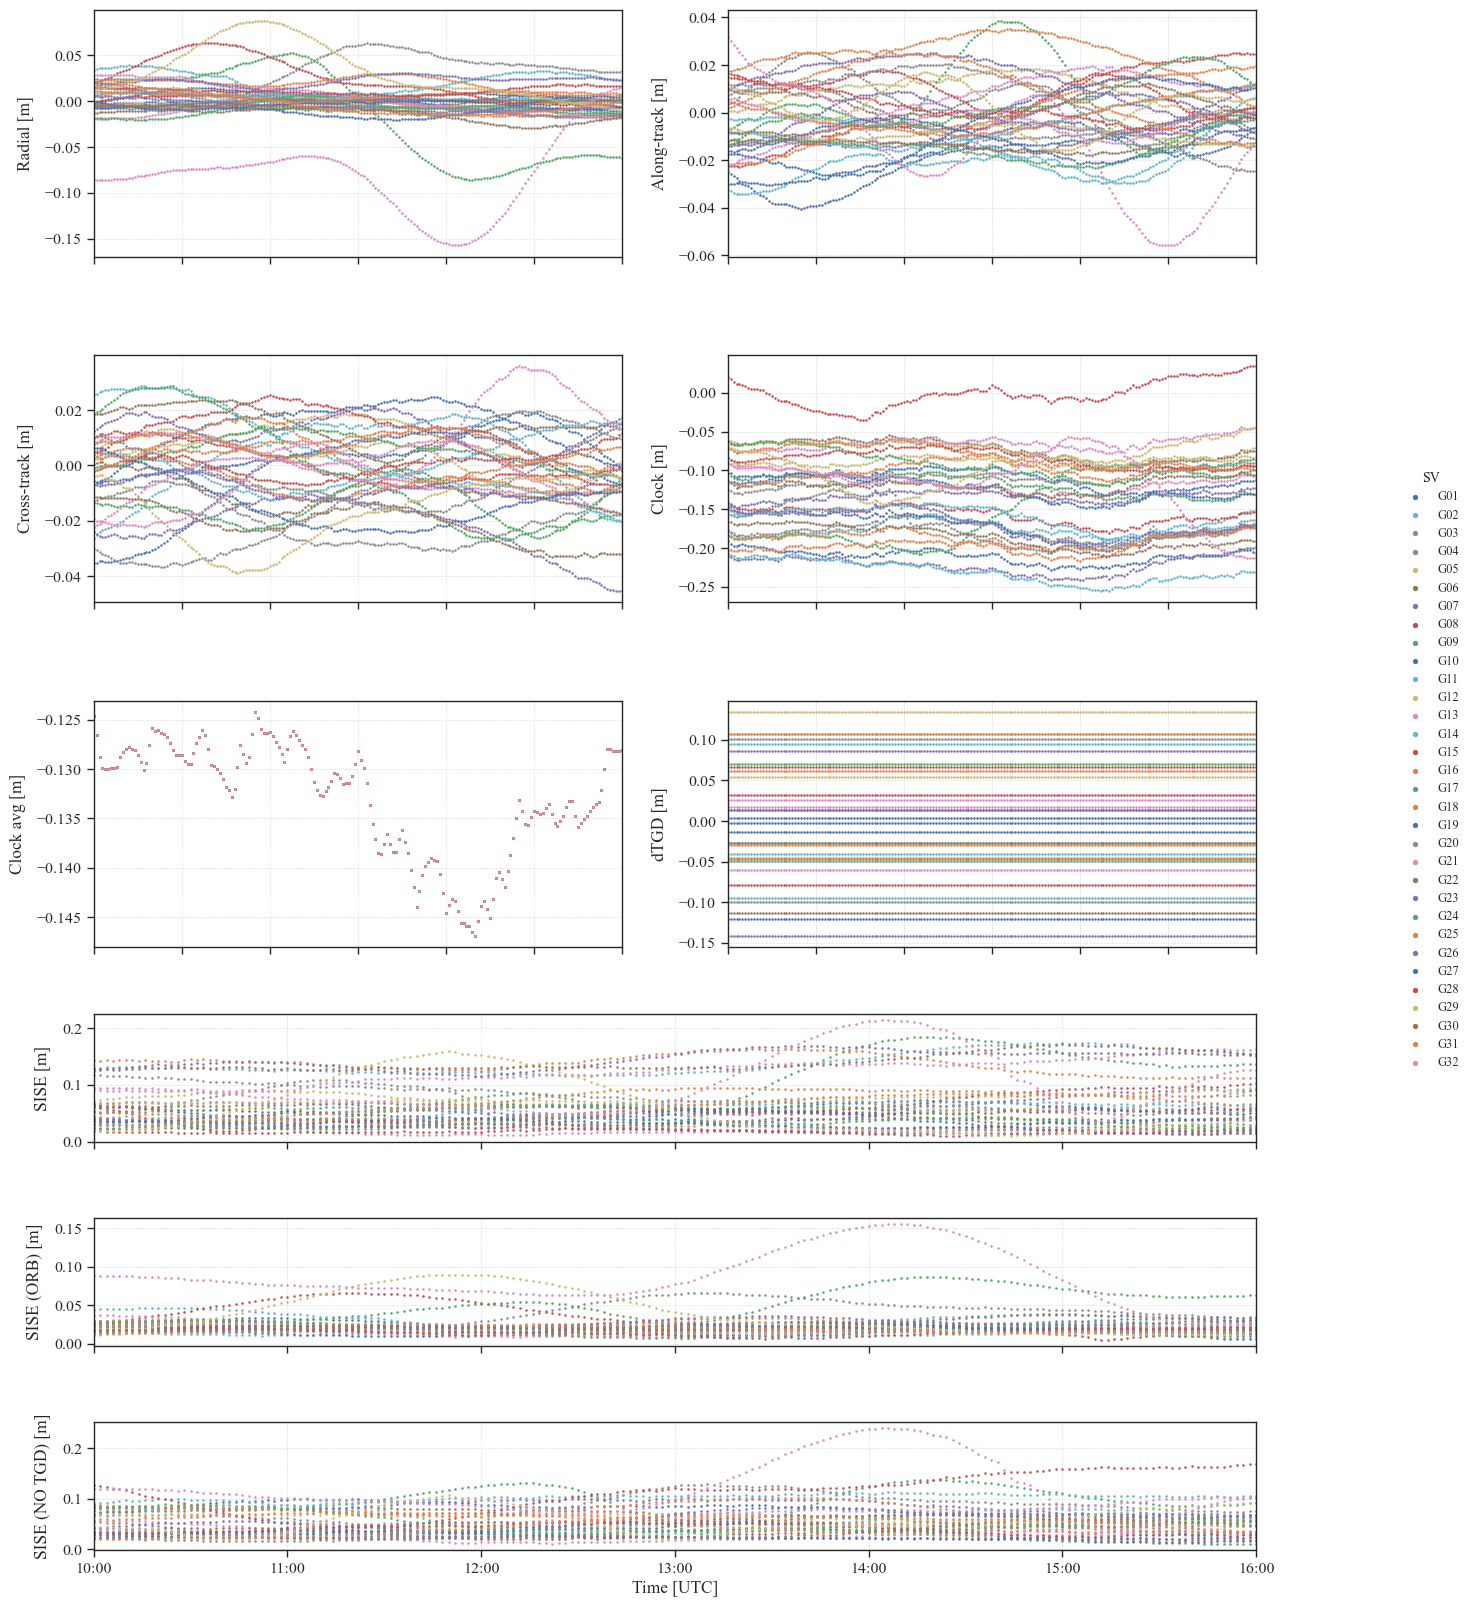

In [34]:
plot_sisre(df=df,out_path='./figures',name='my_precise_orbits')

In [35]:
stats = orbit_stats(df=df,columns='sisre')

In [36]:
df_head(stats,nrows=3,ncols=6)

| sv   |   sisre_min |   sisre_max |   sisre_mean |   sisre_median |   sisre_95% |
|------|-------------|-------------|--------------|----------------|-------------|
| G01  |       0.035 |       0.064 |        0.047 |          0.044 |       0.060 |
| G02  |       0.024 |       0.090 |        0.051 |          0.056 |       0.078 |
| G03  |       0.016 |       0.033 |        0.024 |          0.024 |       0.032 |

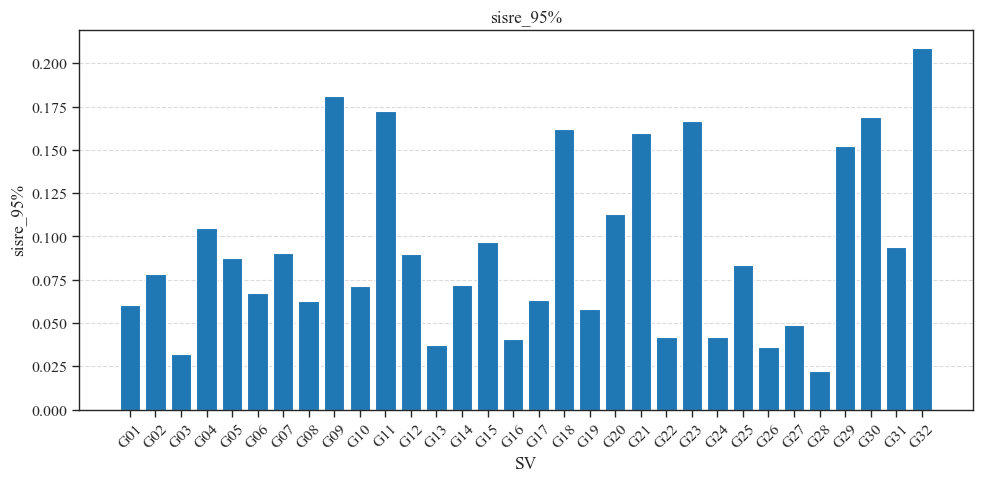

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'sisre_95%'}, xlabel='SV', ylabel='sisre_95%'>)

In [37]:
plot_sv_stats(stats_df=stats,column_stat='sisre_95%')

The result, which indicates that the quality of rapid orbits is significantly better than that of final orbits, is in line with expectations.  We observe 95% SISE at a level of 0.2 - 0.3 metres, while in the case of broadcast orbits it is definitely above 0.5 metres. Analysing the graph, we can see that the clock error and DCB have a significant impact on the error value. This may be useful information when planning PPP measurements. For practice, you can compare selected orbit and DCB products and also compare the results of PPP positioning using these products.

We have discussed the orbits module and its accompanying tools. You have learned about the possibilities offered by GNX-py in this area, how to configure processing, and how to use auxiliary functions for data visualisation. In the next chapter of this tutorial, we will move on to discussing the $ionosphere$ module, which is used to analyse and model the ionosphere.